# Finetune EfficientNet


With 1920x1080 silence-removed melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'efficientnet_1080silence'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.efficientnet_b0(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\profi/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 9.23MB/s]


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Get number of input features to the final layer
num_features = model.classifier[1].in_features

# Replace classifier with a new head for 9 emotion classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_features, 9)  # 9 emotion classes
)

# Step 3: Freeze all layers except the new classifier
for param in model.parameters():
    param.requires_grad = False  # Freeze base layers

for param in model.classifier.parameters():
    param.requires_grad = True  # Only train the classifier

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
from data_preprocessing.AveragePoolResize import AveragePoolResize

learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    AveragePoolResize((224, 224)),  # Resize to 224x224 via average pooling
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 20

C:\Users\profi\AppData\Local\Temp\ipykernel_7016\3223105130.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/20


Validating: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s, Loss=1.2464962005615234, Elapsed=62.6506s, ETA=0.0000s]  


Epoch 1 completed in 306.9141s
Train Loss: 1.3802494728840844 - Train Accuracy: 42.29664638972434
Validation Loss: 1.208900073369344 - Validation Accuracy: 46.7285774588434

Epoch 2/20


Validating: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s, Loss=1.0550944805145264, Elapsed=62.4836s, ETA=0.0000s]  


Epoch 2 completed in 292.3601s
Train Loss: 1.2110719973641324 - Train Accuracy: 48.097057958888314
Validation Loss: 1.1530208738644918 - Validation Accuracy: 48.902490502321655

Epoch 3/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.46it/s, Loss=1.0574965476989746, Elapsed=61.7410s, ETA=0.0000s]  


Epoch 3 completed in 305.2240s
Train Loss: 1.16791011987394 - Train Accuracy: 49.54207277085548
Validation Loss: 1.1193859052658082 - Validation Accuracy: 51.16082735331363

Epoch 4/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.48it/s, Loss=0.9546403884887695, Elapsed=61.2164s, ETA=0.0000s]  


Epoch 4 completed in 302.7788s
Train Loss: 1.1490411825607278 - Train Accuracy: 50.358426991700775
Validation Loss: 1.1104900312423707 - Validation Accuracy: 52.42718446601942

Epoch 5/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.48it/s, Loss=0.9220100045204163, Elapsed=61.1220s, ETA=0.0000s]  


Epoch 5 completed in 301.8069s
Train Loss: 1.1314260930339726 - Train Accuracy: 50.97578073765858
Validation Loss: 1.1002316681543987 - Validation Accuracy: 52.06838328408612

Epoch 6/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.47it/s, Loss=0.9403228759765625, Elapsed=61.5667s, ETA=0.0000s]  


Epoch 6 completed in 302.2308s
Train Loss: 1.1272678680158075 - Train Accuracy: 51.25392912869451
Validation Loss: 1.0955527679125467 - Validation Accuracy: 51.88898269311946

Epoch 7/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.47it/s, Loss=0.9846629500389099, Elapsed=61.2870s, ETA=0.0000s]  


Epoch 7 completed in 301.9494s
Train Loss: 1.1210197086279103 - Train Accuracy: 51.43483865131952
Validation Loss: 1.0831998817125956 - Validation Accuracy: 52.163360067539045

Epoch 8/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.47it/s, Loss=1.0872596502304077, Elapsed=61.4447s, ETA=0.0000s]  


Epoch 8 completed in 302.2039s
Train Loss: 1.1107693349005858 - Train Accuracy: 51.83057823206168
Validation Loss: 1.080320011774699 - Validation Accuracy: 52.986492190797804

Epoch 9/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.46it/s, Loss=1.107966661453247, Elapsed=61.9389s, ETA=0.0000s]   


Epoch 9 completed in 302.6298s
Train Loss: 1.1106235598553122 - Train Accuracy: 51.835100970127314
Validation Loss: 1.080995844999949 - Validation Accuracy: 53.809624314056556

Epoch 10/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.47it/s, Loss=1.081728458404541, Elapsed=61.6517s, ETA=0.0000s]   


Epoch 10 completed in 307.2167s
Train Loss: 1.103815336964723 - Train Accuracy: 52.13812442052419
Validation Loss: 1.0804822834332783 - Validation Accuracy: 52.986492190797804

Epoch 11/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.47it/s, Loss=0.9788283109664917, Elapsed=61.3670s, ETA=0.0000s]  


Epoch 11 completed in 302.6273s
Train Loss: 1.1045927227921568 - Train Accuracy: 52.18109043214763
Validation Loss: 1.075291010538737 - Validation Accuracy: 53.1236808780076

Epoch 12/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.47it/s, Loss=0.9446593523025513, Elapsed=61.4507s, ETA=0.0000s]  


Epoch 12 completed in 301.9383s
Train Loss: 1.1015555471009602 - Train Accuracy: 52.488636620610116
Validation Loss: 1.0735984222094217 - Validation Accuracy: 53.44027015618404

Epoch 13/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.47it/s, Loss=0.8632245659828186, Elapsed=61.3577s, ETA=0.0000s]  


Epoch 13 completed in 302.4767s
Train Loss: 1.1023677925153963 - Train Accuracy: 52.34843174057574
Validation Loss: 1.0726910146077473 - Validation Accuracy: 53.398058252427184

Epoch 14/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.47it/s, Loss=0.9500929117202759, Elapsed=61.4714s, ETA=0.0000s]  


Epoch 14 completed in 302.5547s
Train Loss: 1.100885132316909 - Train Accuracy: 52.13360168245856
Validation Loss: 1.0780714440345764 - Validation Accuracy: 53.58801181933305

Epoch 15/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.47it/s, Loss=1.0736174583435059, Elapsed=61.3857s, ETA=0.0000s]  


Epoch 15 completed in 302.0488s
Train Loss: 1.0976271867063003 - Train Accuracy: 52.44793197801949
Validation Loss: 1.0751726802190145 - Validation Accuracy: 54.55888560574081

Epoch 16/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.48it/s, Loss=0.9725565314292908, Elapsed=61.0545s, ETA=0.0000s]  


Epoch 16 completed in 301.9422s
Train Loss: 1.0963376775986886 - Train Accuracy: 52.68763709549762
Validation Loss: 1.0667437092463175 - Validation Accuracy: 54.3372731110173

Epoch 17/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.48it/s, Loss=0.9279453754425049, Elapsed=61.2557s, ETA=0.0000s]  


Epoch 17 completed in 301.8206s
Train Loss: 1.0924798513768037 - Train Accuracy: 52.74869405938355
Validation Loss: 1.0723182900746664 - Validation Accuracy: 54.84381595609962

Epoch 18/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.47it/s, Loss=1.0297439098358154, Elapsed=61.4380s, ETA=0.0000s]  


Epoch 18 completed in 302.4354s
Train Loss: 1.0958116095879173 - Train Accuracy: 52.41627281156012
Validation Loss: 1.0729173310597737 - Validation Accuracy: 55.60363022372309

Epoch 19/20


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.47it/s, Loss=1.0114554166793823, Elapsed=61.3184s, ETA=0.0000s]  


Epoch 19 completed in 302.0984s
Train Loss: 1.099219552698852 - Train Accuracy: 52.44114787092106
Validation Loss: 1.0665995248158773 - Validation Accuracy: 54.8332629801604

Epoch 20/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.47it/s, Loss=1.0183035135269165, Elapsed=61.6013s, ETA=0.0000s]  

Epoch 20 completed in 302.7317s
Train Loss: 1.0950302283543383 - Train Accuracy: 52.368784061871054
Validation Loss: 1.0670824003219606 - Validation Accuracy: 55.03376952300548



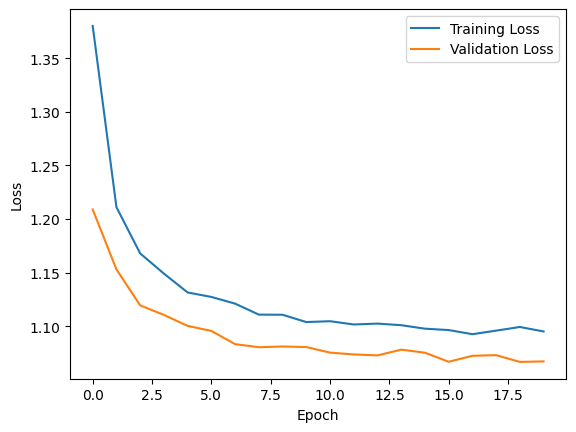

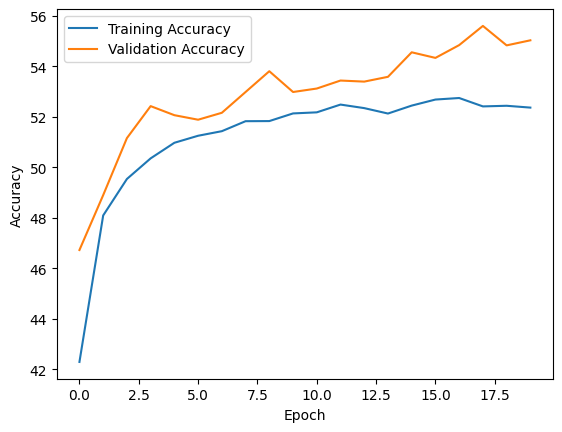

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_7016\3256607076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [01:06<00:00,  1.13it/s]

Test Accuracy: 0.5433
Test Precision: 0.5768
Test Recall: 0.5433
Test F1-score: 0.5308

              precision    recall  f1-score   support

       Anger       0.49      0.61      0.54       916
       Bored       0.64      0.83      0.72      1098
     Disgust       0.33      0.58      0.42       291
        Fear       0.29      0.62      0.39       308
       Happy       0.70      0.28      0.40      1914
     Neutral       0.57      0.40      0.47      2226
    Question       0.60      0.76      0.67      1139
         Sad       0.55      0.59      0.57       857
    Surprise       0.49      0.72      0.59       728

    accuracy                           0.54      9477
   macro avg       0.52      0.60      0.53      9477
weighted avg       0.58      0.54      0.53      9477



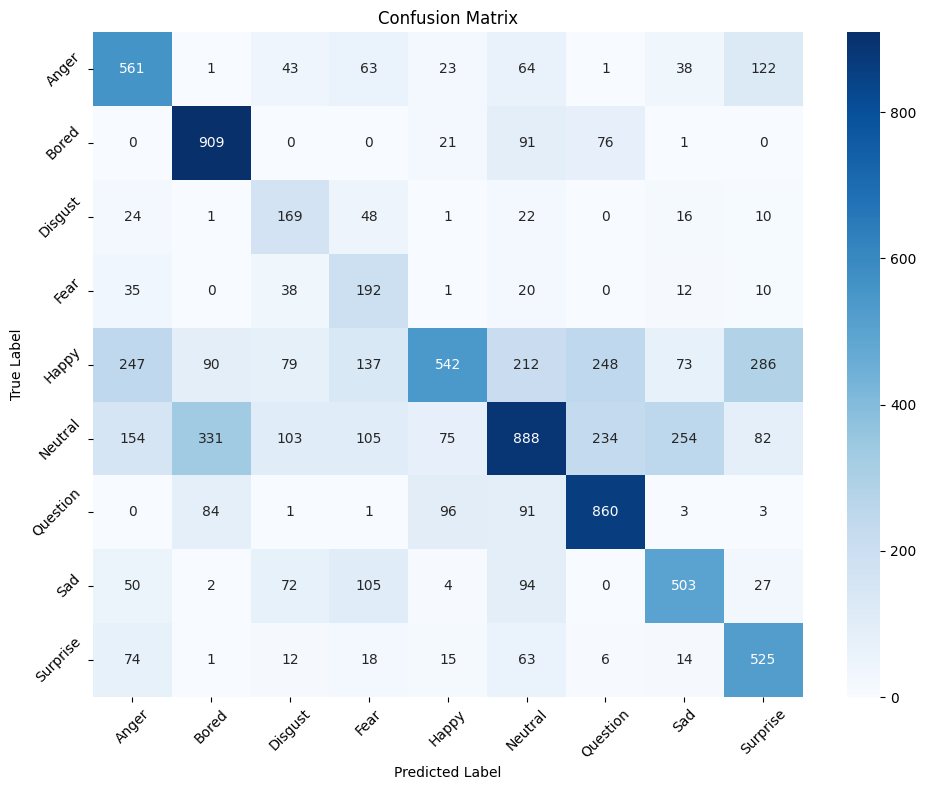

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)